# Notebook: Setting Alert Thresholds with Causal Inference

### Overview 

The goal is to demonstrate how metric thresholds can be improved using causal inference using the Python lib [tfp-causalimpact](https://github.com/google/tfp-causalimpact). 

### Package Requirements

In [144]:
!pip install -q tfp-causalimpact
!pip install -q tensorflow-probability[tf]
!pip install -q pydantic


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


### Module Imports

In [145]:
import datetime as dt
import typing as T

import causalimpact as ci
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pydantic as pdt

In [146]:
plt.ion()

### Utilities

In [149]:
class MockTsVariables(pdt.BaseModel):
    window: T.Annotated[
        int,
        """
        Specifies the duration for which the data should be generated. 
        This parameter defines the range of the time series, starting from end_date and going back by the specified duration.
        """
    ]
    observed_variable: T.Annotated[
        str,
        """
        Specifies the name of the column in the generated DataFrame that contains the metric values. 
        This allows you to define a custom label for the metric being analyzed. 
        For example, daily_denial_count.
        """
    ]
    frequency: T.Annotated[
        str,
        """
        The offset frequency.
        See https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
        """
    ]
    outlier_variability: T.Annotated[
        T.Literal["low", "high"],
        """
        Specifies the magnitude of the outliers to control the severity of anomalies in the generated data.
        
        - "low": Generates outliers with smaller deviations from the typical range of values (e.g., multipliers between 1.5 and 2).
        - "high": Produces more extreme outliers with larger deviations (e.g., multipliers between 2 and 5).   
        """
    ] = "low"



def mock_ts_variables(params: MockTsVariables):    
    # Determine the start date or time based on the window
    start_date = dt.date.today() - pd.to_timedelta(params.window, unit=params.frequency[0].lower())

    # Generate the date range based on the frequency
    date_range = pd.date_range(start=start_date, end=dt.date.today(), freq=params.frequency)

    # Generate random metric values (Poisson distribution for count-like data)
    np.random.seed(42)
    daily_metrics = np.random.poisson(lam=50, size=len(date_range))

    # Adjust the variability of outliers
    if params.outlier_variability == 'low':
        multiplier_range = (1.5, 2)
    elif params.outlier_variability == 'high':
        multiplier_range = (2, 5)
    else:
        raise ValueError("outlier_variability must be either 'low' or 'high'")

    # Introduce outliers
    outlier_indices = np.random.choice(len(daily_metrics), size=int(len(daily_metrics) * 0.05), replace=False)
    multipliers = np.random.uniform(multiplier_range[0], multiplier_range[1], size=len(outlier_indices))
    daily_metrics[outlier_indices] = (daily_metrics[outlier_indices] * multipliers).astype(int)

    # Create the DataFrame
    df = pd.DataFrame({
        "date": date_range,
        params.observed_variable: daily_metrics
    })

    return df

#### Example 1 - Denial Metric

In [150]:

daily_metrics_df = mock_ts_variables(
    params=MockTsVariables(
        observed_variable="denial_count",
        window=365,
        frequency="D",
        outlier_variability="low"
    )
)

In [154]:
print(daily_metrics_df["denial_count"].describe())


count    366.000000
mean      50.931694
std       10.820743
min       29.000000
25%       44.250000
50%       50.000000
75%       55.000000
max      114.000000
Name: denial_count, dtype: float64


`count`: The total number of observations.

`mean`: The average value of the dataset

`std` (Standard Deviation): A measure of the spread or variability in the dataset. A higher value indicates more variability around the mean.

`min`: The smallest value in the dataset.

`25%` (1st Quartile): The value below which 25% of the data falls.

`50%` (Median): The middle value of the dataset.

`75%` (3rd Quartile): The value below which 75% of the data falls.

`max`: The largest value in the dataset.

<Axes: >

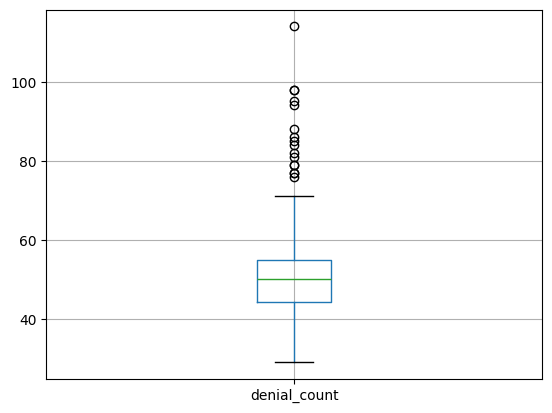

In [155]:
plt.ion()
daily_metrics_df.boxplot(
    column="denial_count", 
    grid=True, 
    return_type="axes"
)

<Axes: title={'center': 'Distribution of Daily Denial Count'}, ylabel='Frequency'>

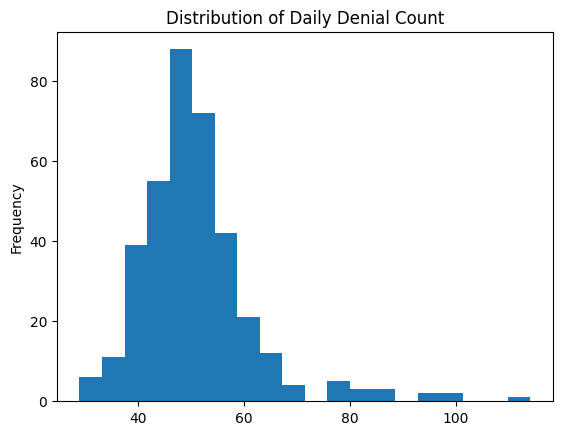

In [152]:
plt.ion()
daily_metrics_df["denial_count"].plot(
    kind="hist", 
    bins=20,
    title="Distribution of Daily Denial Count"
)

<Axes: title={'center': 'Daily Denial Count'}, xlabel='date'>

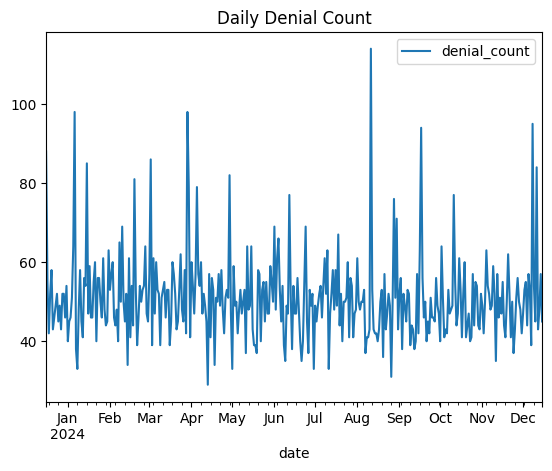

In [120]:
daily_metrics_df.plot(
    x="date", 
    y="denial_count", 
    kind="line", 
    title="Daily Denial Count"
)

### Using Interquartile Range (IQR) for Outlier Bounds

In [ ]:
from scipy.stats import skew

def get_dynamic_iqr_multiplier(data):
    """
    Determine the IQR multiplier dynamically based on skewness.
    """
    # Calculate skewness
    data_skewness = skew(data, nan_policy='omit')

    # Adjust multiplier based on skewness
    if abs(data_skewness) < 0.5:  # Symmetrical
        multiplier = 1.5
    elif abs(data_skewness) < 1:  # Moderately skewed
        multiplier = 2.0
    else:  # Heavily skewed
        multiplier = 2.5

    return multiplier

In [159]:
MULTIPLIER = 1.5

Q1 = daily_metrics_df["denial_count"].quantile(.25)
Q3 = daily_metrics_df["denial_count"].quantile(.75)

IQR = Q3 - Q1

LOWER_BOUND = Q1 - MULTIPLIER * IQR
UPPER_BOUND = Q3 - MULTIPLIER * IQR


# Identify outliers
result_df['is_outlier'] = (daily_metrics_df['denial_count'] < LOWER_BOUND) | (daily_metrics_df['denial_count'] > UPPER_BOUND)

# Display results
print("Lower Bound:", LOWER_BOUND)
print("Upper Bound:", UPPER_BOUND)

Lower Bound: 28.125
Upper Bound: 38.875


In [121]:
pre_period = [daily_metrics_df["date"].min(), daily_metrics_df["date"].max() - dt.timedelta(days=1)]
post_period = [daily_metrics_df["date"].max() - dt.timedelta(days=0), daily_metrics_df["date"].max()]

print(pre_period)
print(post_period)

[Timestamp('2023-12-16 00:00:00'), Timestamp('2024-12-14 00:00:00')]
[Timestamp('2024-12-15 00:00:00'), Timestamp('2024-12-15 00:00:00')]


In [122]:
impact = ci.fit_causalimpact(
    data=daily_metrics_df.set_index("date"),
    pre_period=pre_period,
    post_period=post_period
)

#### summary table details


In [123]:
impact.summary

,actual,predicted,predicted_lower,predicted_upper,predicted_sd,abs_effect,abs_effect_lower,abs_effect_upper,abs_effect_sd,rel_effect,rel_effect_lower,rel_effect_upper,rel_effect_sd,p_value,alpha
average,45.0,50.577171,29.084073,72.555592,11.061799,-5.577171,-27.555592,15.915927,11.061799,-0.062448,-0.379784,0.547284,0.247079,0.294118,0.05
cumulative,45.0,50.577171,29.084073,72.555592,11.061799,-5.577171,-27.555592,15.915927,11.061799,-0.062448,-0.379784,0.547284,0.247079,0.294118,0.05


In [124]:
impact.series

,observed,posterior_mean,posterior_lower,posterior_upper,point_effects_mean,point_effects_lower,point_effects_upper,cumulative_effects_mean,cumulative_effects_lower,cumulative_effects_upper,pre_period_start,pre_period_end,post_period_start,post_period_end
date,,,,,,,,,,,,,,
2023-12-16,88,52.221249,31.201116,72.453766,35.778751,15.546234,56.798884,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15
2023-12-17,55,52.210995,30.164523,73.610156,2.789005,-18.610156,24.835477,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15
2023-12-18,42,52.205051,30.221522,74.921860,-10.205051,-32.921860,11.778478,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15
2023-12-19,52,52.197437,30.536440,76.536648,-0.197437,-24.536648,21.463560,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15
2023-12-20,58,52.187668,31.475913,72.712511,5.812332,-14.712511,26.524087,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-11,84,50.569904,28.442338,69.500264,33.430096,14.499736,55.557662,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15
2024-12-12,43,50.572212,28.796971,70.689329,-7.572212,-27.689329,14.203029,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15
2024-12-13,48,50.571537,29.416659,71.666843,-2.571537,-23.666843,18.583341,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15


In [125]:
ci.plot(impact)

alt.FacetChart(...)

In [126]:
print(ci.summary(impact, output_format='summary'))


Posterior Inference {CausalImpact}
                          Average            Cumulative
Actual                    45.0               45.0
Prediction (s.d.)         50.6 (11.06)       50.6 (11.06)
95% CI                    [29.1, 72.6]       [29.1, 72.6]

Absolute effect (s.d.)    -5.6 (11.06)       -5.6 (11.06)
95% CI                    [-27.6, 15.9]      [-27.6, 15.9]

Relative effect (s.d.)    -6.2% (24.7%)      -6.2% (25.0%)
95% CI                    [-38.0%, 54.7%]    [-38.0%, 54.7%]

Posterior tail-area probability p: 0.294
Posterior prob. of a causal effect: 70.59%

For more details run the command: summary(impact, output_format="report")


/Users/destefano/Desktop/poc-repos/notebooks/myenv/lib/python3.9/site-packages/causalimpact/summary.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ci_model.summary["p_value"][0]


In [139]:
print(ci.summary(impact, output_format="report"))


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 45.0. In the absence of an
intervention, we would have expected an average response of 50.6.
The 95% interval of this counterfactual prediction is [29.1, 72.6].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -5.6 with a 95% interval of
[-27.6, 15.9]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 45.0.
Had the intervention not taken place, we would have expected
a sum of 50.6. The 95% interval of this prediction is [29.1, 72.6].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a decrease of -6.2%. The 95%


/Users/destefano/Desktop/poc-repos/notebooks/myenv/lib/python3.9/site-packages/causalimpact/summary.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ci_model.summary["p_value"][0]


In [ ]:

impact.series['avg_predicted_lower'] = impact.summary["predicted_lower"].iloc[0]
impact.series['avg_predicted_upper'] = impact.summary["predicted_upper"].iloc[0]

impact.series["is_outlier"] = (
    (impact.series["observed"] < impact.series["avg_predicted_lower"]) | 
    (impact.series["observed"] > impact.series["avg_predicted_upper"])
)


In [142]:
result_df: pd.DataFrame = impact.series[[
    'observed', 
    'avg_predicted_lower', 
    'posterior_lower',
    'avg_predicted_upper',
    'posterior_upper',
    'is_outlier'
]].copy()

result_df.sort_index(inplace=True)

cutoff_date = result_df.index.max() - pd.Timedelta(days=90)

last_90_days_df = result_df[result_df.index >= cutoff_date]


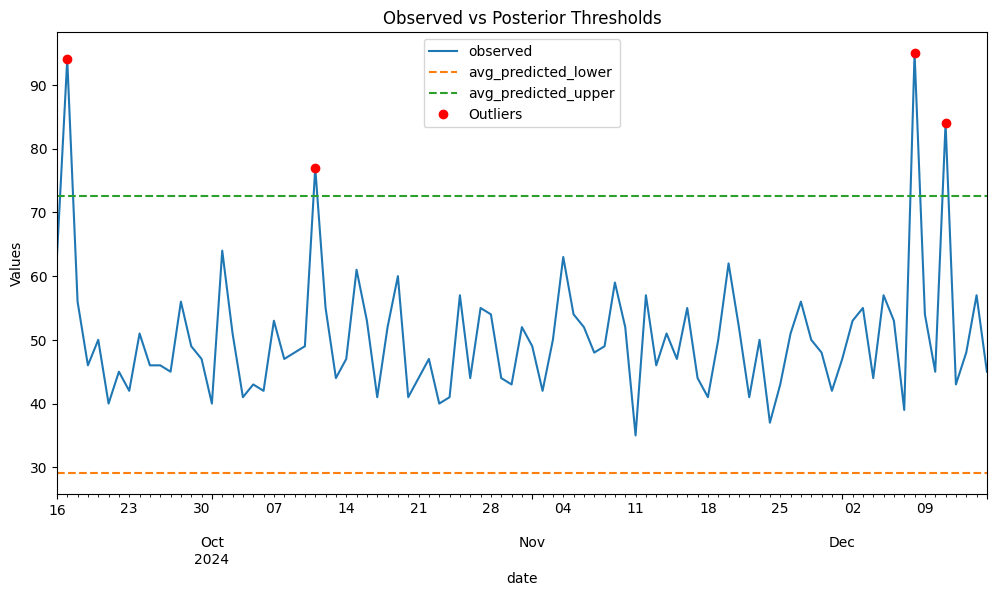

In [143]:

ax = last_90_days_df.plot(
    y=["observed", "avg_predicted_lower", "avg_predicted_upper"],
    style=["-", "--", "--"],
    figsize=(12, 6),
    title="Observed vs Posterior Thresholds",
    ylabel="Values"
)

last_90_days_df[last_90_days_df["is_outlier"]]["observed"].plot(
    ax=ax, 
    style="ro", 
    label="Outliers", 
    markersize=6
)

ax.legend()

This could be improved by adding to covariate values. For example, daily values such as `total_claims_processed`. These values would help improve the fitted model which would narrow the intervals we see. The wider intervals indicate a lack of confidence, which contributes to why we have an statistically insignificant p-value

#### Using IQR instead 

In [158]:
MULTIPLIER = 1.5

Q1 = daily_metrics_df["denial_count"].quantile(.25)
Q3 = daily_metrics_df["denial_count"].quantile(.75)

IQR = Q3 - Q1

LOWER_BOUND = Q1 - MULTIPLIER * IQR
UPPER_BOUND = Q3 - MULTIPLIER * IQR


# Identify outliers
result_df['is_outlier'] = (daily_metrics_df['denial_count'] < LOWER_BOUND) | (daily_metrics_df['denial_count'] > UPPER_BOUND)

# Display results
print("Lower Bound:", LOWER_BOUND)
print("Upper Bound:", UPPER_BOUND)

Lower Bound: 28.125
Upper Bound: 38.875


In [ ]:
ax = last_90_days_df.plot(
    y=["observed", "avg_predicted_lower", "avg_predicted_upper"],
    style=["-", "--", "--"],
    figsize=(12, 6),
    title="Observed vs Posterior Thresholds",
    ylabel="Values"
)

last_90_days_df[last_90_days_df["is_outlier"]]["observed"].plot(
    ax=ax, 
    style="ro", 
    label="Outliers", 
    markersize=6
)

ax.legend()